<a id='top'></a>
# Google Analytics Customer Revenue Prediction improve on baseline test
This kernel uses the new dataset **[GA data with json columns](https://www.kaggle.com/colinpearse/ga-analytics-with-json-columns)** which was converted using **[Google Analytics Data Without Pesky JSON](https://www.kaggle.com/colinpearse/google-analytics-data-without-pesky-json)**. This means newly initialised runs don't have to wait the five minutes or so for converting the JSON fields in train and test.

This Kernel has the following sections.

#### [Initialisation](#initialisation) Importing, listing directories, reading the data and defining generic functions.

#### [Simplify the data](#simplify) Dropping, creating, converting columns and printing a summary.

#### [EDA: pie and scatter](#eda) Pie charts and scatter graphs a plenty.

#### [Prepare the data](#prepare) Choosing the most useful columns, splitting the data into train and validation parts, encoding it and printing a summary.

#### [The Neural Net](#neuralnet) Putting the data through LightGBM for a baseline score.

<br>*NaN values: The pie and scatter chart functions use fillna(-1) because it yields useful information. However, filling NaN with -1 did not improve the baseline score. Q. would any "NaN filler" improve the machine learning score? "0" is not represented in the data but it seems intuitvely confusing to use this as a replacement for NaN.*

##### Useful websites
https://pandas.pydata.org/pandas-docs/stable/api.html#flat-file

<a id='initialisation'></a>
# Initialisation
Import, set up globals, list the contents of directories, read in the files and define some generic functions.
<br>*NOTE: `fullVisitorId`s identify as numeric and non-numeric so force this to be a string*

The pie charts and scatter graphs may be cumbersome once viewed so use `do_for_loop_pies = False` and `do_for_loop_scatters = False` to skip these.

[Next section - Simplify the data](#simplify) &nbsp;&nbsp;&nbsp; [Top of page](#top)

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import json
import re
import time
from math import ceil
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

warnings.filterwarnings('ignore')
orig_max_rows = pd.options.display.max_rows
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_colwidth', 90)

UNDERLINE = '\033[4m'
BOLD = '\033[1m'
END = '\033[0m'

#newdata_dir = "../input"
newdata_dir = "../input/ga-analytics-with-json-columns"
data_dir = '../input/ga-customer-revenue-prediction'
#working_dir = "."
working_dir = newdata_dir
newtrain_path = newdata_dir+"/newtrain_v2.csv"
newtest_path  = newdata_dir+"/newtest_v2.csv"
submission_path  = working_dir+"/submission_lgb.csv"
!ls -ld $newdata_dir/*.csv

-rwxrwxrwx 1 colin colin       7255 Oct 25 21:18 ../input/ga-analytics-with-json-columns/ga_20170601.csv
-rwxrwxrwx 1 colin colin       1157 Oct 25 21:20 ../input/ga-analytics-with-json-columns/ga_20170601_fromtrain.csv
-rwxrwxrwx 1 colin colin    1212669 Oct 25 21:36 ../input/ga-analytics-with-json-columns/ga_20170801_20180430_rev_gt0.csv
-rwxrwxrwx 1 colin colin  222497940 Oct 28 21:32 ../input/ga-analytics-with-json-columns/newtest.csv
-rwxrwxrwx 1 colin colin 1791015312 Nov 29 08:08 ../input/ga-analytics-with-json-columns/newtest_v2_BAD.csv
-rwxrwxrwx 1 colin colin 1791015311 Nov 29 18:59 ../input/ga-analytics-with-json-columns/newtest_v2.csv
-rwxrwxrwx 1 colin colin  244350270 Oct 28 21:31 ../input/ga-analytics-with-json-columns/newtrain.csv
-rwxrwxrwx 1 colin colin 6298048094 Nov 29 03:18 ../input/ga-analytics-with-json-columns/newtrain_v2_BAD.csv
-rwxrwxrwx 1 colin colin 6298048081 Nov 29 19:05 ../input/ga-analytics-with-json-columns/newtrain_v2.csv
-rwxrwxrwx 1 colin colin   18

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// Kaggle fails on the above lines

<IPython.core.display.Javascript object>

### Generic data functions
* summary: info="describe" and default ("basic") are be self-explanatory; info="revenue" has special columns:
<br>'nNull' are non-Null entries for quick checks
<br>'nRevs' are non-Null **totals.transactionRevenue** entries only for the non-Null entries of the column
<br>'nNull%' is the % of nNull to overall rows
<br>'nRevs%' is the % of nRevs to overall non-Null revenue entries

*NOTE: `display.max_rows` is set to the number of columns, if the original max_rows is less*

*NaN WARNING: since many functions use count(), dropna(), isna(), dropna() beware reusing them after manipulation with fillna()*

In [3]:
def summary(df, info="describe", cols=None):
    if info == "describe":
        headings=['Null','dType','Type','MinMax','Mean','Std','Skew','Unique','Examples']
    elif info == "revenue":
        headings=['Null','nNull','nRevs','nNull%','nRevs%','dType','Type','Unique','Examples']    
        nrevs = df['totals.transactionRevenue'].count()
    else:
        headings=['Null','dType','Type','Unique','Examples']

    if cols == None:
        cols = df.columns

    nrows = df.shape[0]
    if (nrows > orig_max_rows):
        pd.set_option('display.max_rows', nrows)

    print('DataFrame shape',df.shape)
    sdf = pd.DataFrame(index=cols, columns=headings)
    for col in cols:
        sys.stdout.write('.')
        sys.stdout.flush()
        sdf['Null'][col]     = df[col].isna().sum()
        sdf['Unique'][col]   = len(list(df[col].unique()))
        sdf['dType'][col]    = df[col].dtypes
        sdf['Type'][col]     = "-" if df[col].notna().sum() == 0 else type(df[col].dropna().iloc[0])
        sdf['Examples'][col] = "-" if df[col].notna().sum() == 0 else list(df[col].unique())
        if info == "describe":
            if 'float' in str(df[col].dtype) or 'int' in str(df[col].dtype):
                sdf['MinMax'][col] = str(round(df[col].min(),2))+'/'+str(round(df[col].max(),2))
                sdf['Mean'][col]   = df[col].mean()
                sdf['Std'][col]    = df[col].std()
                sdf['Skew'][col]   = df[col].skew()
        elif info == "revenue":
            sdf['nNull'][col] = df[col].count()
            sdf['nRevs'][col] = df.groupby(col)['totals.transactionRevenue'].count().sum()
            sdf['nNull%'][col] = round(sdf['nNull'][col] / (nrows/100), 1)
            sdf['nRevs%'][col] = round(sdf['nRevs'][col] / (nrevs/100), 1)
    return sdf.fillna('-')

<a id='simplify'></a>
# Loading only relevant data
Since v2 (even the json/list/dict modified one) is still 6GB so load only relevant columns. I extracted what's relevant with faster shell scripts offline. The main changes are keeping four columns from the new 'hits' column in v2.

_NOTE: test_v2 data has revenue column made (by Google's algorithm?) for cross checking_

[Next section - EDA: pie and scatter](#eda) &nbsp;&nbsp;&nbsp; [Top of page](#top)

In [4]:
%%time
relevantcols = [
    'channelGrouping',
    'date',
    'fullVisitorId',
    'socialEngagementType',
    'visitId',
    'visitNumber',
    'visitStartTime',
    'device.browser',
    'device.deviceCategory',
    'device.isMobile',
    'device.operatingSystem',
    'geoNetwork.city',
    'geoNetwork.continent',
    'geoNetwork.country',
    'geoNetwork.metro',
    'geoNetwork.networkDomain',
    'geoNetwork.region',
    'geoNetwork.subContinent',
    'totals.bounces',
    'totals.hits',
    'totals.newVisits',
    'totals.pageviews',
    'totals.visits',
    'totals.transactionRevenue',
    'trafficSource.adContent',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.page',
    'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaign',
    'trafficSource.isTrueDirect',
    'trafficSource.keyword',
    'trafficSource.medium',
    'trafficSource.referralPath',
    'trafficSource.source',
    'hits.list.contentGroup.previousContentGroup2',
    'hits.list.eCommerceAction.option',
    'hits.list.item.transactionId',
    'hits.list.transaction.affiliation',
    'hits.list.eventInfo.eventAction',
    'hits.list.eventInfo.eventLabel',
    'hits.list.transaction.transactionRevenue',
    'hits.list.transaction.transactionShipping',
    'hits.list.transaction.transactionTax',
    ]

# PROBLEM: have problem where visitStartTime has other fields mixed in (original csv is ok)
# - usecols does not work
# - trying names instead of usecols - NO
# - trying df = pd.read_csv(...)[cols]
#newtrain = pd.read_csv(newtrain_path, dtype={'fullVisitorId': 'str', 'visitId': 'str'})[relevantcols]
newtest = pd.read_csv(newtest_path, dtype={'fullVisitorId': 'str', 'visitId': 'str'})[relevantcols]
newtrain = newtest.copy()

CPU times: user 16.8 s, sys: 1.33 s, total: 18.1 s
Wall time: 22.2 s


In [5]:
# Don't bother shuffling new column around
#def move_last_col(df, col, insert_after):
#    ordercols = list(df.columns[:-1].insert(insert_after, col))
#    return df[ordercols]

def add_visitStartTimeHH(df):
    df['visitStartTimeHH'] = pd.to_datetime(df['visitStartTime'], unit='s').apply(
        lambda x: re.sub(r'^[^ \s]+ (\d\d):\d\d:\d\d',r'\1', str(x))).astype(int)
    return df

def add_visitStartTimeMM(df):
    df['visitStartTimeMM'] = pd.to_datetime(df['visitStartTime'], unit='s').apply(
        lambda x: re.sub(r'^[^ \s]+ \d\d:(\d\d):\d\d',r'\1', str(x))).astype(int)
    return df

def add_dateMm(df):
    df['dateMm'] = df['date'].apply(lambda x: re.sub(r'^\d\d\d\d(\d\d)\d\d',r'\1', str(x))).astype(int)
    return df

# replace arbitrary string with its length in the hope of creating consistent values
#def str2strlen(df, col):
#    df['tmp.'+col] = df[col].str.count(".")
#    df.drop(columns=[col], inplace=True)
#    df.rename(columns={'tmp.'+col: col}, inplace=True)
#    print (list(newtrain[col].unique()))
#    return df

In [6]:
# % of strings in trafficSource.referralPath where revenue>0:
# gt_average: significantly more than the train average of 1.27%: / (exactly "/"), merch, mail, store
# lt_average: significantly less than the train average of 1.27%: about, using, html
# function to get gt_average, lt_average
# 1. list all unique entries, join them, convert non-[A-Za-z0-9] to '-', extract strings 4 or more chars
# 2. find each string in all entries to get quantity (q)
# 3. as above, but also where where revenue>0 (qr)
# 4. make a list: string, q, qr/(q/100)  <- % of q where revenue>0
# 5. gt_average: save those well above 1.27% (% rev>0 found in train data) - how much?
# 6. lt_average: same but well below 1.27% - how much
    
def col_replace(df, col, gt_average, lt_average):
    for keepstr in list(set(gt_average + lt_average)):
        df[col].replace(regex=[r'^.*(?P<type>'+keepstr+').*$'], value='keep_\g<type>', inplace=True)
    df[col].replace(regex=[r'^(?!keep_).*$'], value='remainder', inplace=True)
    print (list(df[col].unique()))

In [7]:
print ("train/test: add visitStartTimeHH")
newtrain = add_visitStartTimeHH(newtrain)
newtest  = add_visitStartTimeHH(newtest)

#print ("train/test: add visitStartTimeMM")
#newtrain = add_visitStartTimeMM(newtrain)
#newtest  = add_visitStartTimeMM(newtest)

print ("train/test: add dateMm")
newtrain = add_dateMm(newtrain)
newtest  = add_dateMm(newtest)

print ("train/test: sorting by visitStartTime")
newtrain.sort_values(by=['visitStartTime'], inplace=True)
newtest.sort_values(by=['visitStartTime'], inplace=True)

train/test: add visitStartTimeHH
train/test: add dateMm
train/test: sorting by visitStartTime


In [8]:
# criteria: 1000 instances of word in list, gt 1.5% rev>0, lt 0.5% rev>0

# less than 50 entries, but I can try to use these
print ("\n trafficSource.campaign")
gt_average = ['Accessories','Dynamic','Search','Site','Whole']
lt_average = ['Data','Share','Promo']
col_replace(newtrain, 'trafficSource.campaign', gt_average, lt_average)
col_replace(newtest, 'trafficSource.campaign', gt_average, lt_average)

# more than 50 entries
print ("\n trafficSource.adwordsClickInfo.gclId")
gt_average = ["Cj0KEQiA", "8P8HAQ", "Cj0KEQjw", "EAIaIQobChMI", "CjwKEAiA", "EALw", "CjwKCAjw"]
lt_average = []
col_replace(newtrain, 'trafficSource.adwordsClickInfo.gclId', gt_average, lt_average)
col_replace(newtest, 'trafficSource.adwordsClickInfo.gclId', gt_average, lt_average)

print ("\n trafficSource.keyword")
gt_average = ["merch", "merchandise", "Google", "Merchandise", "6qEhsCssdK0z36ri", "1hZbAqLCbjwfgOH7"]
lt_average = ["shirt", "youtube", "tube", "targeting", "Content", "Remarketing"]
col_replace(newtrain, 'trafficSource.keyword', gt_average, lt_average)
col_replace(newtest, 'trafficSource.keyword', gt_average, lt_average)

print ("\n trafficSource.referralPath")
gt_average = ["offer", "2145", "site", "google", "deal", "forum", "store", "merch", "merchandise", "mail"]
lt_average = ["about", "gopher", "comments", "copyright", "html", "logo", "permissions", "using", "launch", "Google", "Head", "Visit", "View"]
col_replace(newtrain, 'trafficSource.referralPath', gt_average, lt_average)
col_replace(newtest, 'trafficSource.referralPath', gt_average, lt_average)

print ("\n trafficSource.source")
gt_average = ["yahoo", "gdeals", "google", "groups", "mail", "googleplex", "mall"]
lt_average = ["youtube", "reddit", "Partners", "quora"]
col_replace(newtrain, 'trafficSource.source', gt_average, lt_average)
col_replace(newtest, 'trafficSource.source', gt_average, lt_average)

# criteria: picked out salient words which differed between rev=0 and rev>0
print ("\n hits.list.contentGroup.previousContentGroup2")
keeplist = ["Accessories", "Apparel", "Bags", "Brands", "Drinkware", "Electronics", "Lifestyle", "Nest", "Office"]
col_replace(newtrain, 'hits.list.contentGroup.previousContentGroup2', keeplist, [])
col_replace(newtest, 'hits.list.contentGroup.previousContentGroup2', keeplist, [])

print ("\n hits.list.eCommerceAction.option")
col_replace(newtrain, 'hits.list.eCommerceAction.option', ["Billing", "Payment", "Review"], [])
col_replace(newtest, 'hits.list.eCommerceAction.option', ["Billing", "Payment", "Review"], [])

print ("\n hits.list.item.transactionId")
col_replace(newtrain, 'hits.list.item.transactionId', ["ORD"], [])
col_replace(newtest, 'hits.list.item.transactionId', ["ORD"], [])

print ("\n hits.list.transaction.affiliation")
col_replace(newtrain, 'hits.list.transaction.affiliation', ["Merchandise"], [])
col_replace(newtest, 'hits.list.transaction.affiliation', ["Merchandise"], [])

print ("\n hits.list.eventInfo.eventAction")
keeplist = ["Add", "Onsite", "Product", "Promotion", "Quickview", "Remove"]
col_replace(newtrain, 'hits.list.eventInfo.eventAction', keeplist, [])
col_replace(newtest, 'hits.list.eventInfo.eventAction', keeplist, [])

print ("\n hits.list.eventInfo.eventLabel")
keeplist = ['Android','Baby','Back','Backpack','Bag','Ball','Balm','Beanie','Bib','Bike','Black','Blue',
            'Board','Bot','Bottle','Braille','Cable','Can','Canvas','Cap','Cappy','Car','Card','Card-','Cell',
            'Charcoal','Clear','Clip','Cloth','Contigo','Crew','Crewneck','Dash','Decal','Device','Dog','Eco',
            'Email','Emoji','Engineer','Favorite','Fit','Flashlight','Flower','Fold','Frisbee','Gear',
            'Gel','Gift','Glass','Go','Google','Green','Grey','Happy','Hat','Heather','Heather/Black','Hood',
            'Hoodie','Hub','Icon','Jacket','Journal','Kick','Kids','Kit','Laptop','Large','LED','Light',
            'Lines','Lip','Mat','Matrix','Maze','Men','Mesh','Metal','Metallic','Micro','Microfleece','Mini',
            'M/L','Mood','Mouse','Mug','Mustachio','Navy','Ninja','Notebook','of','on','Onesie','Organizer',
            'Original','oz','Pack','Pad','Peace','Pen','Phone','Pom','Pouch','Pro','Protector','Pull','Pullover',
            'Purple','Recycled','Red','Removable','Rolltop','Rucksack','Sandwich','Sanitizer','Set','Sheet',
            'Short','Silver','Sleeve','Small','Snapback','Socks','Sport','Stand','Standard','Stic','Stick',
            'Sticker','Stickers','Stretch','Stylus','Sunglasses','Sweatshirt','Tee','The','Thermal','To',
            'Toddler','Tone','Tote','Trace','Transmission','Tri','Trucker','Tube','Tumbler','Twill',
            'Typography','Unisex','Utility','Wall','Water','Waze','White','Window','Windup','Women','Wool',
            'Wordmark','Yellow','You','YouTube','Zip']
col_replace(newtrain, 'hits.list.eventInfo.eventLabel', keeplist, [])
col_replace(newtest, 'hits.list.eventInfo.eventLabel', keeplist, [])


 trafficSource.campaign
[nan, 'keep_Promo', 'remainder', 'keep_Accessories', 'keep_Dynamic']
[nan, 'keep_Promo', 'remainder', 'keep_Accessories', 'keep_Dynamic']

 trafficSource.adwordsClickInfo.gclId
[nan, 'keep_EAIaIQobChMI', 'keep_CjwKCAjw', 'keep_EALw', 'remainder']
[nan, 'keep_EAIaIQobChMI', 'keep_CjwKCAjw', 'keep_EALw', 'remainder']

 trafficSource.keyword
[nan, 'remainder', 'keep_Google', 'keep_merch', 'keep_shirt', 'keep_tube', 'keep_Merchandise']
[nan, 'remainder', 'keep_Google', 'keep_merch', 'keep_shirt', 'keep_tube', 'keep_Merchandise']

 trafficSource.referralPath
['remainder', nan, 'keep_about', 'keep_html', 'keep_using', 'keep_google', 'keep_deal', 'keep_merch', 'keep_Google', 'keep_comments', 'keep_offer', 'keep_forum', 'keep_mail', 'keep_gopher', 'keep_site', 'keep_store', 'keep_copyright', 'keep_launch', 'keep_logo', 'keep_View']
['remainder', nan, 'keep_about', 'keep_html', 'keep_using', 'keep_google', 'keep_deal', 'keep_merch', 'keep_Google', 'keep_comments', 'keep

In [9]:
summary(newtrain, info="revenue")

DataFrame shape (401589, 47)
...............................................

,Null,nNull,nRevs,nNull%,nRevs%,dType,Type,Unique,Examples
channelGrouping,0,401589,4594,100.0,100.0,object,<class 'str'>,8,"[Referral, Direct, Social, Organic Search, Pai..."
date,0,401589,4594,100.0,100.0,int64,<class 'numpy.int64'>,168,"[20180501, 20180502, 20180503, 20180504, 20180..."
fullVisitorId,0,401589,4594,100.0,100.0,object,<class 'str'>,296530,"[1778456890803926940, 3835551007029341267, 938..."
socialEngagementType,0,401589,4594,100.0,100.0,object,<class 'str'>,1,[Not Socially Engaged]
visitId,0,401589,4594,100.0,100.0,object,<class 'str'>,393181,"[1525157352, 1525158049, 1525158072, 152515807..."
visitNumber,0,401589,4594,100.0,100.0,int64,<class 'numpy.int64'>,386,"[1, 4, 3, 5, 2, 6, 37, 9, 12, 8, 7, 13, 80, 14..."
visitStartTime,0,401589,4594,100.0,100.0,int64,<class 'numpy.int64'>,393643,"[1525158007, 1525158049, 1525158072, 152515807..."
device.browser,0,401589,4594,100.0,100.0,object,<class 'str'>,62,"[Chrome, Samsung Internet, Opera Mini, Safari,..."
device.deviceCategory,0,401589,4594,100.0,100.0,object,<class 'str'>,3,"[desktop, mobile, tablet]"
device.isMobile,0,401589,4594,100.0,100.0,bool,<class 'numpy.bool_'>,2,"[False, True]"


In [10]:
summary(newtest, info="basic")

DataFrame shape (401589, 47)
...............................................

,Null,dType,Type,Unique,Examples
channelGrouping,0,object,<class 'str'>,8,"[Referral, Direct, Social, Organic Search, Pai..."
date,0,int64,<class 'numpy.int64'>,168,"[20180501, 20180502, 20180503, 20180504, 20180..."
fullVisitorId,0,object,<class 'str'>,296530,"[1778456890803926940, 3835551007029341267, 938..."
socialEngagementType,0,object,<class 'str'>,1,[Not Socially Engaged]
visitId,0,object,<class 'str'>,393181,"[1525157352, 1525158049, 1525158072, 152515807..."
visitNumber,0,int64,<class 'numpy.int64'>,386,"[1, 4, 3, 5, 2, 6, 37, 9, 12, 8, 7, 13, 80, 14..."
visitStartTime,0,int64,<class 'numpy.int64'>,393643,"[1525158007, 1525158049, 1525158072, 152515807..."
device.browser,0,object,<class 'str'>,62,"[Chrome, Samsung Internet, Opera Mini, Safari,..."
device.deviceCategory,0,object,<class 'str'>,3,"[desktop, mobile, tablet]"
device.isMobile,0,bool,<class 'numpy.bool_'>,2,"[False, True]"


<a id='eda'></a>
# EDA: pie and scatter
Firsty, a bar chart to show the imbalance of the revenue column.

Then, pie charts and scatter graphs are used to assess unique entries in the columns and how they correlate. Pies are used when a column's unique entries &lt;= 1000 and scatter graphs are used when unique entries &gt;= 100, so there's plenty of overlap.

Three charts/graphs are produced for each column:
<br>(a) general prevalence of an entry, eg. November has the most entries overall;
<br>(b) prevalence when revenue &gt; 0, eg. December has the most entries when it comes to spending money;
<br>(c) prevalence for revenue quantity, eg. August has the biggest slice when it comes to how much money is spent.

*Q. Is there a function to pull out the hundreds/thousands of unique column entries and produce two lists of correlation values which would contain all the information of (a), (b) and (c)?*

The last part of this sections deals with `fullVisitorId`. I want to know how much overlap there is between the unique entries of this column in the train and test data.

[Next section - Prepare the data](#prepare) &nbsp;&nbsp;&nbsp; [Top of page](#top)

### Bar graph to state the obvious
Rows where revenue&gt;0 is 1.27% of the data.
*<br>Q. Does duplicating rows where revenue&gt;0 improve the score?
<br>Q. Does creating "similar" rows (to prevent over-fitting) improve the score?*

nrows = 401589; NaN = 396995; >0 = 4594; 1.14%


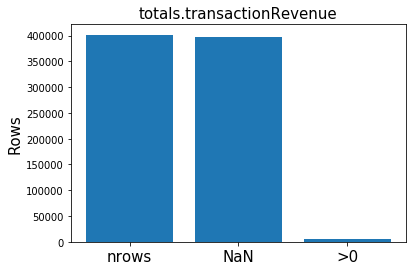

In [11]:
def mybar_rows(data, labels=[], title="title"):
    drange = list(range(1,len(data)+1))
    plt.bar(drange, data)
    plt.ylabel('Rows', fontsize=15)
    plt.xticks(drange, labels, fontsize=15, rotation=0)
    plt.title(title, fontsize=15);
    plt.show()

nrows = newtrain['totals.transactionRevenue'].size
nrevs = newtrain['totals.transactionRevenue'].dropna().size
zrevs = nrows - nrevs

print ("nrows = {:d}; NaN = {:d}; >0 = {:d}; {:1.2f}%".format(nrows,zrevs,nrevs,nrevs/(nrows/100)))
mybar_rows([nrows, zrevs, nrevs], labels=["nrows", "NaN", ">0"], title="totals.transactionRevenue")

### Pie chart functions
* ifsort: function to sort depending on sorty
* col_by_size: overall prevalence of values in **col&#42;**; ignore if count <= threshold
* col_by_col_count: count col2 instances for each unique value of **col1&#42;**; but ignore if count <= threshold
* col_by_col_sum: sum col2 instances for each unique value of **col1&#42;**; but ignore if sum <=threshold
* myautopct: pie is messy with 0.0 and 0.1 percent markings, so set a threshold
* get_colors: to assign the same colour for index labels
* get_labels: to assign a name or no name based on the value (to avoid clutter)
* mypie: common options
* make_revenue_pie: show 3 pies showing column prevalence (a) overall (b) by revenue instance and (c) by revenue sum

** *&#42;col (or col1) is filled with -1 instead of NaN. -1 has no meaning in the entire data set (neither does 0 but I thought -1 more obvious so). Doing this allows the pie/scatter graphs to highlight usefulness of columns like ..adwords.., which are typically >90% NaNs* **

In [12]:
def ifsort(df, sorty=True):
    return df.sort_values(ascending=True) if sorty is True else df

def col_by_size(df, col, threshold=0, sorty=True):
    return ifsort(df.fillna({col: -1}).groupby(col).size().apply(lambda x: (x if x>threshold else np.nan)).dropna(), sorty=sorty)

def col_by_col_count(df, col1, col2, threshold=0, sorty=True):
    return ifsort(df.fillna({col1: -1}).groupby(col1)[col2].count().apply(lambda x: (x if x>threshold else np.nan)).dropna(), sorty=sorty)

def col_by_col_sum(df, col1, col2, threshold=0, sorty=True):
    return ifsort(df.fillna({col1: -1}).groupby(col1)[col2].sum(numeric_only=True).apply(lambda x: (x if x>threshold else np.nan)).dropna(), sorty=sorty)

def myautopct(pct):
    return ('%.2f' % pct) if pct > 2 else ''

def get_colors(df):
    colors = []
    for i in df.index:
        s = str(abs(hash(str(i))))
        colors.append( ( float('0.'+s[0]), float('0.'+s[1]), float('0.'+s[2]) ) )
    return colors

def get_labels(df):
    labels = []
    total = df.values.sum()
    for i,v in dict(df).items():
        pct = v / (total/100)
        labels.append( ( i if pct > 1 else '' ) )
    return labels

def mypie(df, title, angle=0, autocol=True, autolab=True):
    colors = get_colors(df) if autocol is True else None
    labels = get_labels(df) if autolab is True else None
    # autopct='%1.1f%%'
    # textprops={'size': 'small'}  (Kaggle python (3.6.6) + libs didn't recognise this)
    df.plot(kind='pie', radius=1.2, startangle=angle, autopct=myautopct, pctdistance=0.8,
        figsize=(5, 5), rotatelabels=False, legend=True, colors=colors, labels=labels, explode=[0.02]*df.size);
    plt.title(title, weight='bold', size=14, x=2.0, y=-0.01);
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(2.5, 1.0), ncol=2, fontsize=10, fancybox=True, shadow=True);
    
def make_revenue_pie(df, col, unique=500, minperc=0, threshold=0, angle=0, sorty=True):
    print ('\n\n'+BOLD+UNDERLINE+'Making a pie for',col,"..."+END)
    uentries = df[col].astype(str).unique().size
    percvalid = df[col].notna().sum() / (df[col].size / 100)
    if percvalid < minperc:
        print ("NO PIE because {:s} has only {:1.1f}% non-Null entries (min={:d}%)".format(col, percvalid, minperc))
    elif uentries > unique:
        print ("NO PIE because there are over",unique,"unique",col,"entries")
    elif uentries <= 1:
        print ("NO PIE because all entries are identical")
    else:
        dfrev = col_by_col_count(df, col, 'totals.transactionRevenue', threshold=threshold, sorty=sorty)
        if not dfrev.empty:
            dfsum = col_by_col_sum(df, col, 'totals.transactionRevenue', threshold=threshold, sorty=sorty)
            dfgen = col_by_size(df, col, threshold=threshold, sorty=sorty)
            mypie(dfgen, col+' prevalence',           angle=angle, autocol=True); plt.show()
            mypie(dfrev, col+' by revenue instances', angle=angle, autocol=True); plt.show()
            mypie(dfsum, col+' by revenue sum',       angle=angle, autocol=True); plt.show()
        else:
            print ("NO PIE because",col," does not have a unique entry with more than",threshold,"revenue instances")

### Pie example deductions using example dateMm
As mentioned above, the albeit subtle differences can be seen for November, December and August in the three respective pies.

EXAMPLE:


Making a pie for hits.list.contentGroup.previousContentGroup2 ...


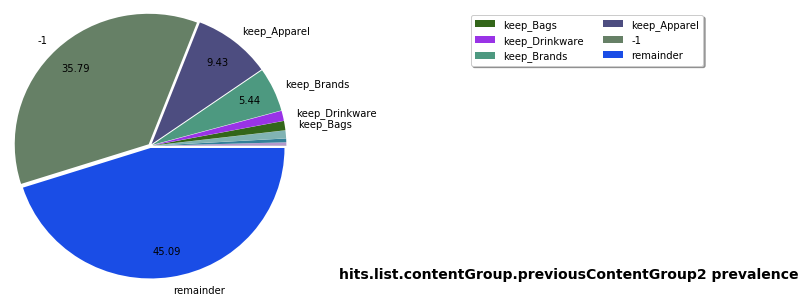

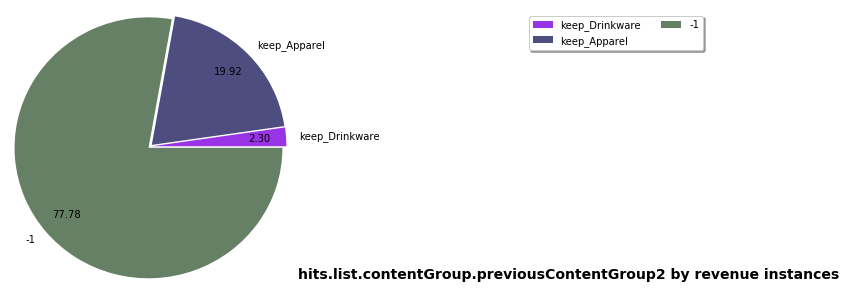

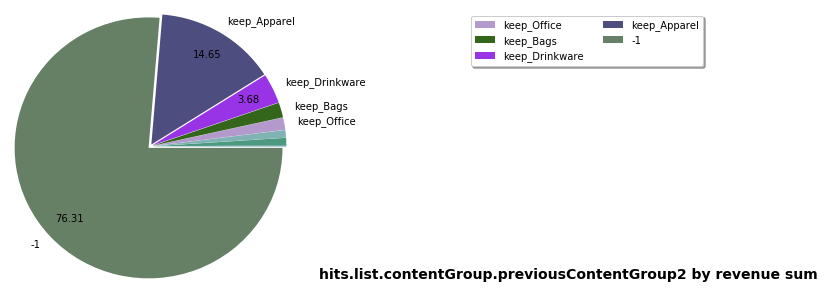



Making a pie for hits.list.eCommerceAction.option ...


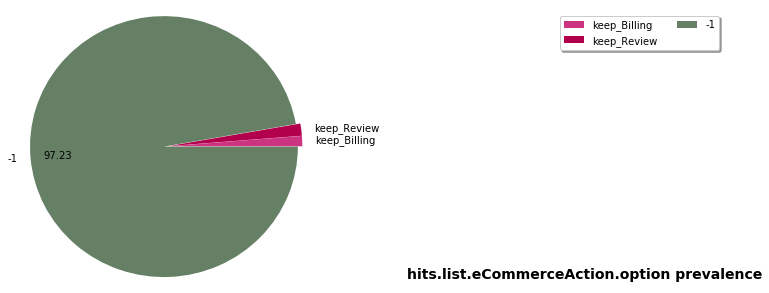

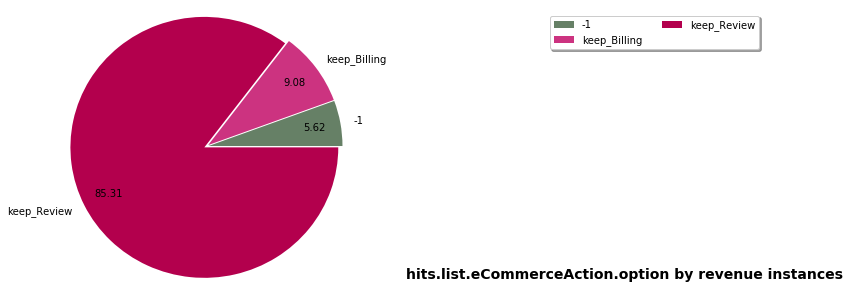

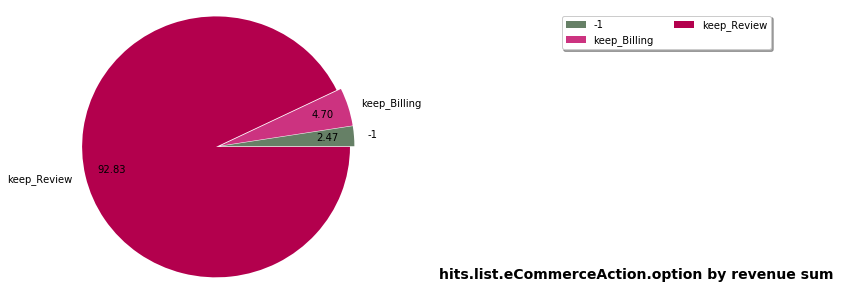



Making a pie for hits.list.item.transactionId ...


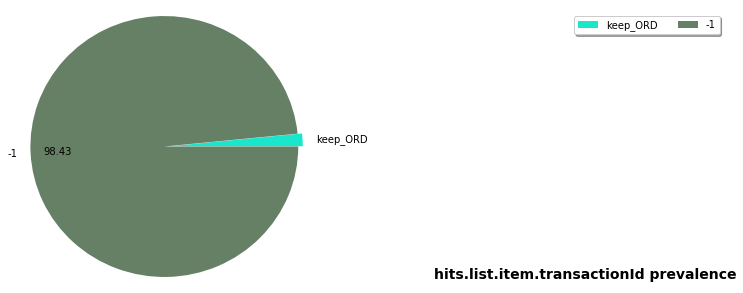

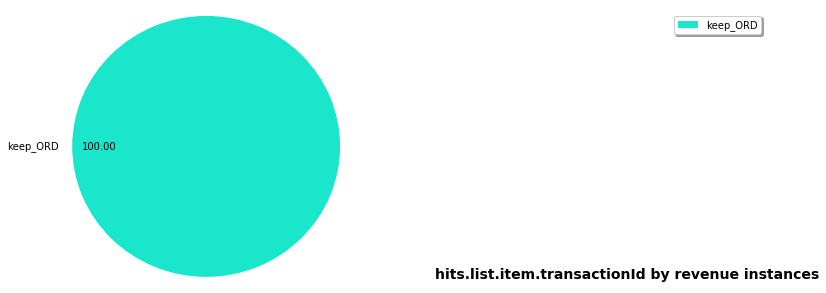

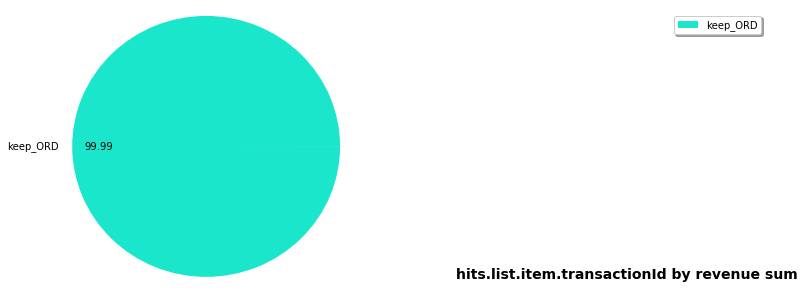



Making a pie for hits.list.transaction.affiliation ...


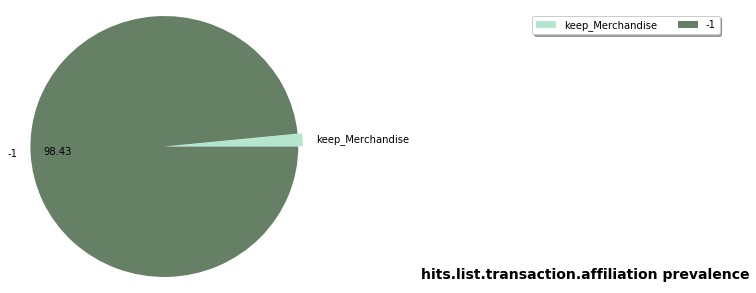

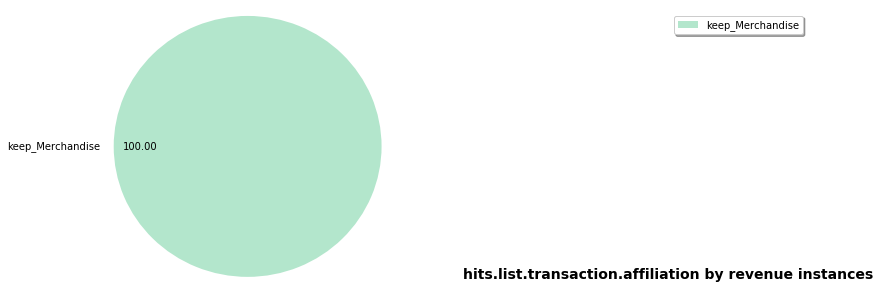

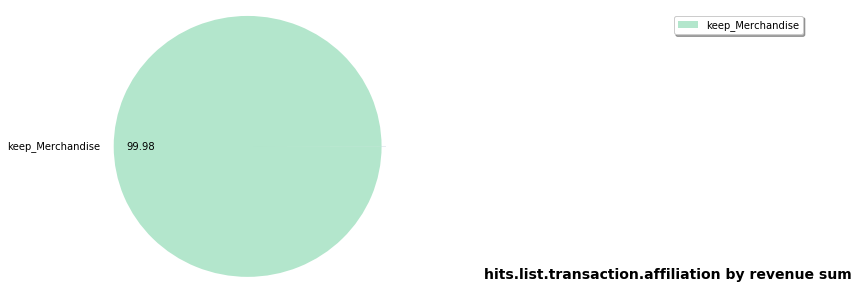



Making a pie for hits.list.eventInfo.eventAction ...


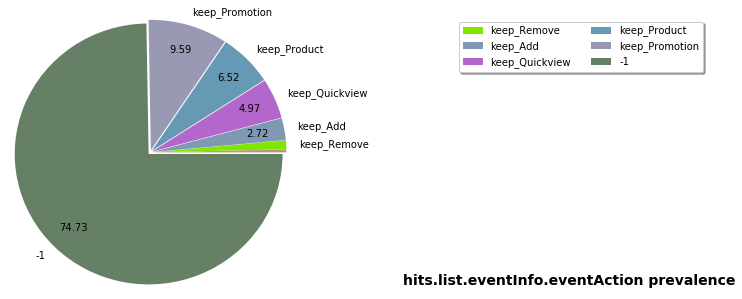

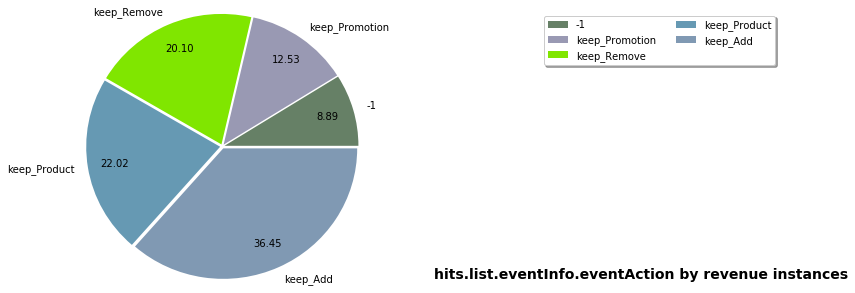

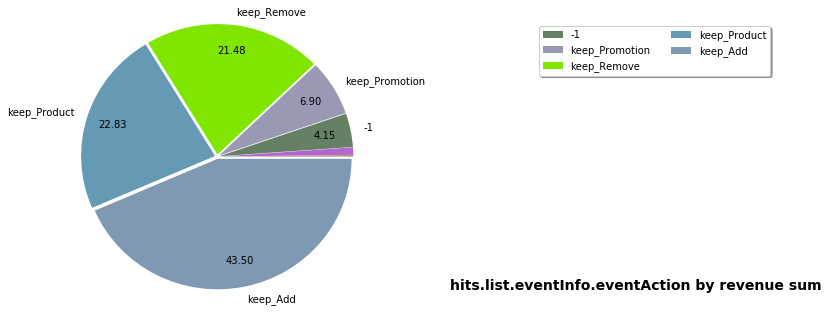



Making a pie for hits.list.eventInfo.eventLabel ...


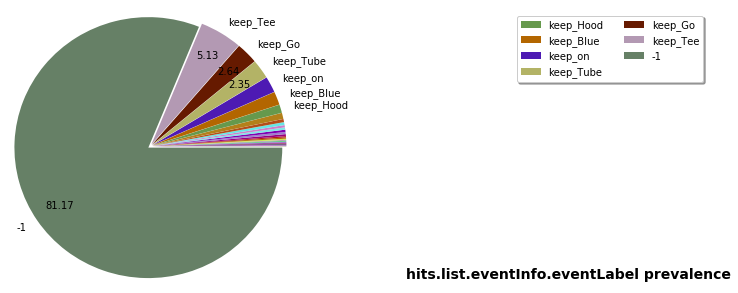

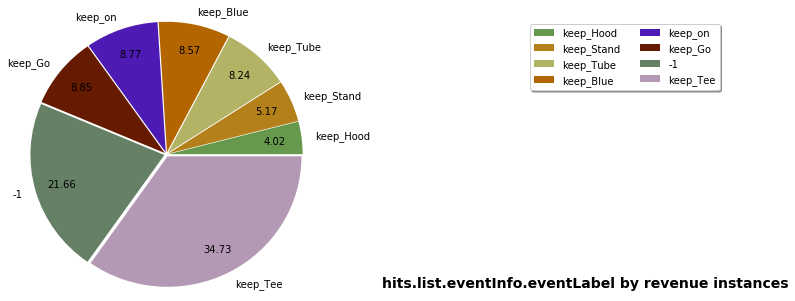

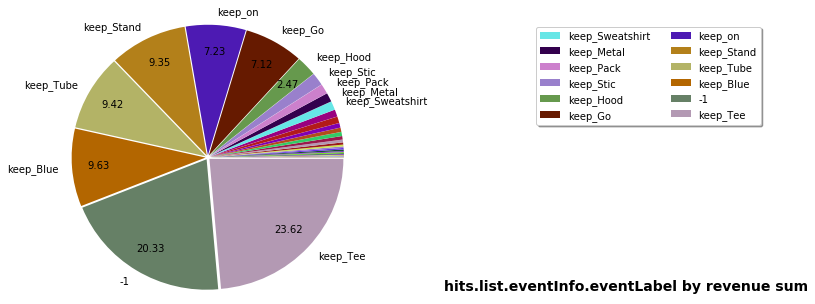

In [13]:
print (BOLD+'EXAMPLE:'+END)
#make_revenue_pie(newtrain, 'dateMm', unique=1000, threshold=100, angle=0)
#make_revenue_pie(newtrain, 'device.operatingSystem', unique=1000, threshold=100, angle=0, sorty=False)
#make_revenue_pie(newtrain, 'geoNetwork.subContinent', unique=1000, threshold=100, angle=0)
#make_revenue_pie(newtrain, 'geoNetwork.region', unique=1000, threshold=100, angle=0)
#make_revenue_pie(newtrain, 'socialEngagementType', unique=1000, threshold=100, angle=0)
#make_revenue_pie(newtrain, 'visitStartTimeHH', unique=1000, threshold=100, angle=0)
#make_revenue_pie(newtrain, 'trafficSource.adwordsClickInfo.adNetworkType', unique=1000, threshold=100, angle=0)
for col in ['hits.list.contentGroup.previousContentGroup2',
            'hits.list.eCommerceAction.option',
            'hits.list.item.transactionId',
            'hits.list.transaction.affiliation',
            'hits.list.eventInfo.eventAction',
            'hits.list.eventInfo.eventLabel',
           ]:
    make_revenue_pie(newtrain, col, unique=1000, threshold=100, angle=0)

### Scatter graph functions
* truncate: truncate strings within an array
* get_xticks: make sure the xticks are readable and that the last (highest) is always shown
* myscat: good options for a scatter graph
* myscat_size: plot non-zero values only and max 'maxtick' labels for col prevalence
* myscat_countrev: plot non-zero values only and max 'maxtick' labels for col by revenue instances
* myscat_sumrev: plot non-zero values only and max 'maxtick' labels for col by revenue sum
* scatter_revenue: plot only for those > than unique
<br>*NOTE: natural log is used to compress the results when `log1p=True`*

Next, an examples of three scatter graphs for `totals.hits`. After that a for loop does the same for all columns where unique entries >= 100.

In [14]:
def truncate(avals, tlen):
    tstrs = []
    tstrs[:] = (re.sub(r'(.{'+str(tlen)+'})(.*)', r'\1......', str(val)) for val in avals)
    return tstrs

def get_xticks(df, maxtick=39):
    rows = df.shape[0]
    xti = list(range(0, rows, ceil(rows/maxtick)))
    #xtl = list(df.index)[0::ceil(rows/maxtick)]
    xtl = truncate(list(df.index)[0::ceil(rows/maxtick)], 30)
    if xtl[-1] != df.index[-1]:
        xti.append(rows)
        xtl.append(df.index[-1])
    return xti, xtl

def myscat(df, col1, col2, log1p=True, sorty=True, threshold=0):
    ylabel = "ln("+col2+")"      if log1p is True else col2
    ytmp   = np.log1p(df.values) if log1p is True else df.values
    y      = np.sort(ytmp)       if sorty is True else ytmp
    x      = range(0, len(y))
    #print ("NOTE:",len(y),"unique entries found where each value >",threshold,"(threshold) ; meaning",len(y),"data points for both x and y")
    plt.figure(figsize=(15,5))
    plt.scatter(x, y)
    plt.xlabel(col1, fontsize=12)
    plt.ylabel(ylabel+" > "+str(threshold), fontsize=12)
    xti, xtl = get_xticks(df)
    plt.xticks(xti, xtl, rotation=90)
    plt.show()

def myscat_size(df, col, log1p=True, threshold=0, sorty=True):
    dfsize = col_by_size(newtrain, col, threshold=threshold, sorty=sorty)
    myscat(dfsize, col, 'number of rows', log1p=log1p, sorty=sorty, threshold=threshold)

def myscat_countrev(df, col, log1p=True, threshold=0, sorty=True):
    dfcount = col_by_col_count(newtrain, col, 'totals.transactionRevenue', threshold=threshold, sorty=sorty)
    myscat(dfcount, col, 'totals.transactionRevenue', log1p=log1p, sorty=sorty, threshold=threshold)

def myscat_sumrev(df, col, log1p=True, threshold=0, sorty=True):
    dfsum = col_by_col_sum(newtrain, col, 'totals.transactionRevenue', threshold=threshold, sorty=sorty)
    myscat(dfsum, col, 'totals.transactionRevenue', log1p=log1p, sorty=sorty, threshold=threshold)

def scatter_revenue(df, col, unique=100, threshold=0, sorty=True):
    print ('\n\n'+BOLD+UNDERLINE+'Scatter graphs for',col,"(a) prevalence (b) by revenue instances (c) by revenue sum ("+('sorted' if sorty is True else 'unsorted')+")"+END)
    uentries = df[col].dropna().astype(str).unique().size
    if uentries < unique:
        print ("NO SCATTER because there are under",unique,"unique",col,"entries")
    else:
        myscat_size    (newtrain, col, log1p=True, threshold=threshold, sorty=sorty)
        myscat_countrev(newtrain, col, log1p=True, threshold=threshold, sorty=sorty)
        myscat_sumrev  (newtrain, col, log1p=True, threshold=threshold, sorty=sorty)

### Scatter example deductions using example totals.hits
Graph (a) shows a steady overall decline in quantity of hits from 1-500, but graphs (b) and (c) show a revenue sweetspot between 20-30 hits.

EXAMPLE:


Scatter graphs for totals.hits (a) prevalence (b) by revenue instances (c) by revenue sum (unsorted)


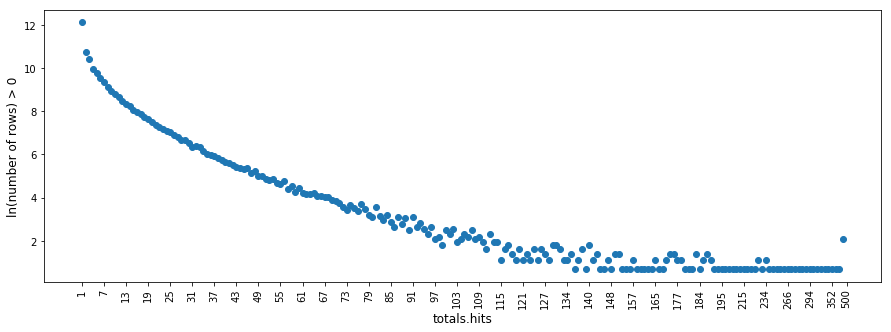

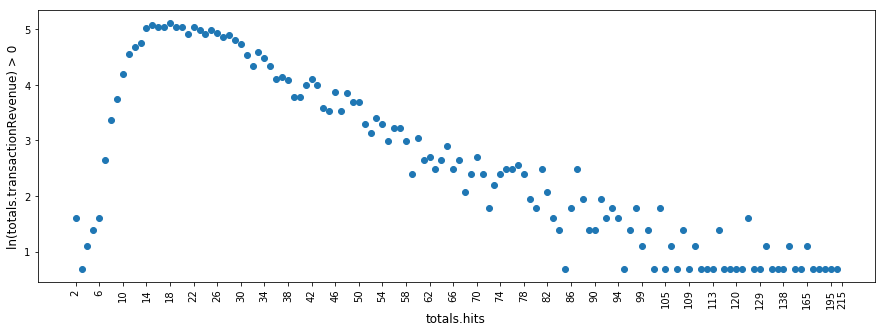

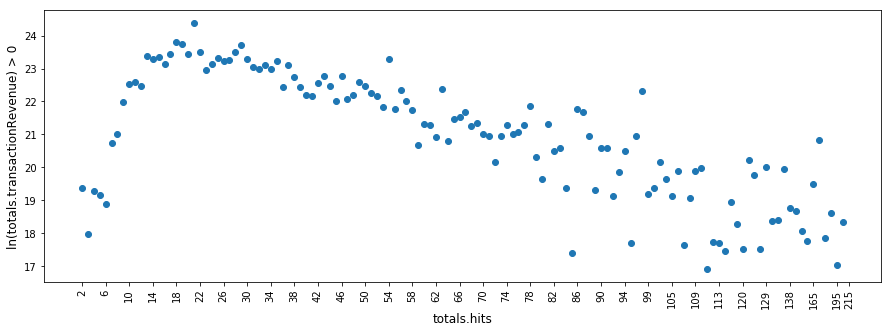

In [15]:
print (BOLD+'EXAMPLE:'+END)
#scatter_revenue(newtrain, 'trafficSource.referralPath', unique=0, threshold=0, sorty=False)
#scatter_revenue(newtrain, 'fullVisitorId', unique=0, threshold=0, sorty=True)
scatter_revenue(newtrain, 'totals.hits', unique=0, threshold=0, sorty=False)

### Scatter graph for all columns with 100 or more unique entries
The 3 graphs show the following for each column:
<br>&nbsp;&nbsp;a) column prevalence for each unique entry; value is number of rows per unique entry
<br>&nbsp;&nbsp;b) column by revenue instance; value is number of "revenue>0" rows per unique entry
<br>&nbsp;&nbsp;c) column by revenue sum; value is sum of those same revenue rows per unique entry

NOTE:
* due to the large proportion of revenue NaN rows, graph (a) is expected to be more or less the same as a graph showing column by "revenue==0" instances
* sort y (revenue) when x is type(object) but for other types (int/float) leave it sorted on x
* NaNs are filled using fillna(-1) temporarily before showing the graphs

A summary of the scatter graph observations are listed below along with columns judged already useful/not sure/not useful from previous sections. The columns listed below should be the same columns in our initial `summary(newtrain, info="revenue")` line, ie. after the drop of NaN-only columns at the beginning.

#### make useful
* trafficSource.adwordsClickInfo.gclId
* trafficSource.adContent
* trafficSource.adwordsClickInfo.adNetworkType
* trafficSource.adwordsClickInfo.isVideoAd
* trafficSource.adwordsClickInfo.page
* trafficSource.adwordsClickInfo.slot
* trafficSource.campaign

#### useful from pie and scatter
* trafficSource.keyword: some random words, some real words, like for revenue for Google Merchandise
* trafficSource.referralPath: strings random and real, maybe a conversion is needed to something more generic
* trafficSource.source: real strings that show pattern
* trafficSource.isTrueDirect: +ve True; -ve NaN
* trafficSource.medium: +ve referral,cpc; -ve: organic search,affiliate
* trafficSource.source: +ve mail.googleplex.com,(direct); -ve google,youtube.com
* visitNumber: revenue goes up with visits
* geoNetwork.networkDomain: few domains give high revenue
* totals.hits: interesting, unsorted yet graph (b) and (c) shows a definite pattern which is different to (a)
* totals.pageviews: interesting for the same reason as totals.hits above
* channelGrouping: +ve Referral; -ve Organic Search
* date: split into month only
* dateMm: +ve Dec,Apr,Aug -ve other months
* visitStartTimeHH: +ve 6pm-midnight -ve other times
* visitNumber: +ve 2-10 (possibly more); -ve 1
* device.browser: +ve Chrome; -ve Safari
* device.deviceCategory: +ve desktop; -ve mobile
* device.isMobile: +ve False; -ve True (corroborates the above data)
* device.operatingSystem: +ve Mac,Linux,Chrome; -ve Windows,Android,iOS
* geoNetwork.city: +ve many US cities; -ve non-US cities
* geoNetwork.continent: +ve Americas; -ve other continents
* geoNetwork.country: +ve USA; -ve non-USA
* geoNetwork.metro; something going on but a function could calculate +ve -ve better
* geoNetwork.region; something going on but a function could calculate +ve -ve better
* geoNetwork.subContinent; +ve North America; -ve all other sub-continents
* totals.bounces: +ve NaN; -ve 1.0
* totals.hits: +ve >10; -ve <10
* totals.pageviews: +ve >10; -ve <10
* totals.newVisits: +ve NaN; -ve 1.0

#### check (see section after graphs)
* fullVisitorId: check will show overlap (of unique values) between train and test data is not large enough

#### not useful
* visitId: unique numbers that won't be found in test data
* sessionId: unique numbers that won't be found in test data
* socialEngagementType: see pie section
* totals.visits: see pie section
* trafficSource.campaignCode: one value NaN11251kjhkvahf, and the rest are NaNs
* totals.transactionRevenue: value we're trying to predict

### Check fullVisitorId unique entries in train and test
As the test below shows the unique entries from this column is less than 1% of the data sample. In baseline tests with LightGBM, adding/removing `fullVisitorId` didn't make much difference.

*Q. How do I improve score by using those small number of unique values that appear in both newtrain and newtest?*

In [16]:
def check_unique_values(df1, df2, col):
    l1 = list(df1[col].dropna().astype(str).unique()) 
    l2 = list(df2[col].dropna().astype(str).unique()) 
    return len(l1), len(l2), len(list(set(l1) & set(l2)))

def check_unique_values_with_revenue(df1, df2, col):
    l1 = col_by_col_count(df1, col, 'totals.transactionRevenue', threshold=0, sorty=False).index
    l2 = list(df2[col].dropna().astype(str).unique()) 
    return len(l1), len(l2), len(list(set(l1) & set(l2)))

trows = newtest.shape[0]
print ("{:d} rows in newtrain".format(newtrain.shape[0]))
print ("{:d} rows in newtest".format(trows))
for col in ['fullVisitorId']:
    q1,  q2,  qsame  = check_unique_values(newtrain, newtest, col)
    rq1, rq2, rqsame = check_unique_values_with_revenue(newtrain, newtest, col)
    print ("")
    print ("{:s}: {:d} unique entries in newtrain".format(col,q1))
    print ("{:s}: {:d} unique entries in newtest".format(col,q2))
    print ("{:s}: {:d} unique entries in both ({:1.2f}% of newtest)".format(col,qsame,qsame/(trows/100)))
    print ("{:s}: {:d} of the {:d} have rev>0 ({:1.2f}% of {:d})".format(col,rqsame,qsame,rqsame/(qsame/100),qsame))

401589 rows in newtrain
401589 rows in newtest

fullVisitorId: 296530 unique entries in newtrain
fullVisitorId: 296530 unique entries in newtest
fullVisitorId: 296530 unique entries in both (73.84% of newtest)
fullVisitorId: 4156 of the 296530 have rev>0 (1.40% of 296530)


In [17]:
test2017    = newtrain.loc[(20170501 <= newtrain['date'])].loc[(newtrain['date'] <= 20171005)]
competition = newtrain.loc[(20171201 <= newtrain['date'])].loc[(newtrain['date'] <= 20180131)]
trows = competition.shape[0]
print ("{:d} rows in equivalent 5 month period in 2017 (ie. test data)".format(test2017.shape[0]))
print ("{:d} rows in equivalent 2 month period in 2017/18 (ie. competition data)".format(trows))
q1,  q2,  qsame  = check_unique_values(test2017, competition, 'fullVisitorId')
rq1, rq2, rqsame = check_unique_values_with_revenue(test2017, competition, 'fullVisitorId')
print ("")
print ("{:d} unique visitors for the equivalent test data period".format(q1))
print ("{:d} unique visitors for the equivalent competition data period".format(q2))
print ("{:d} unique visitors in both ({:1.2f}% of {:d})".format(qsame,qsame/(trows/100),q2))
print ("{:d} of the {:d} have rev>0 ({:1.2f}% of {:d})".format(rqsame,qsame,rqsame/(qsame/100),qsame))

0 rows in equivalent 5 month period in 2017 (ie. test data)
0 rows in equivalent 2 month period in 2017/18 (ie. competition data)

0 unique visitors for the equivalent test data period
0 unique visitors for the equivalent competition data period


ZeroDivisionError: float division by zero

<a id='prepare'></a>
# Prepare the data
Here we define the useful columns, split the data into training and validation, do some sanity checks and encode the data.

For v2 the dates are:
* train_v2   01/08/2016 -> 30/04/2018 21 months
* test_v2    01/05/2018 -> 05/10/2018  5 months - has revenue column so I will use as validation data
* prediction 01/12/2018 -> 31/01/2019  2 months

So the Nov 2018 revenue submission should predict Dec/Jan 2019 data and in Feb 2019 the results are posted.

Try:
* use test_v2 as validation and don't split train_v2
* join train_v2 and test_v2 and then split
* save predictions using train_v2 and actual revenue from test_v2 and compare the two

If we have:
* 1323730 unique visitors in the training data over 21 months
* 296530 unique visitors in test data over 5 months
* and only 2759 are in both data sets, only 195 of which have rev>0
* so we can expect a fraction of those 296530 unique visitors to spend money during the 2 competition months

The equivalent time last year would be:
* 305597 unique visitors for the equivalent test data period in 2017
* 144049 unique visitors for the equivalent competition data period 17/18
* and only 2174 are in both data sets (1.20% of 144049), only 176 of which have rev>0 (8.10% of 2174)
* so (assuming a similar overlap this year) our algorithm has to identify approximately 200 visitors with rev>0 from approximately 150,000 unique visitors and correctly mark the remaining 149,800 as rev=0 (since all except 2000 of these will not be back)

[Next section - The Neural Net](#neuralnet) &nbsp;&nbsp;&nbsp; [Top of page](#top)

### Define useful columns
The columns for training data should be the same as test except for the extra `totals.transactionRevenue` column, which will be removed later. Also, the columns `date` and `fullVisitorId` are used in checks too, so these need to be included now too. If they are not needed they should be removed later.

In [18]:
useful_test_cols = [
    'fullVisitorId',
    'date',
    'dateMm',
    'visitStartTimeHH',
    'channelGrouping',
    'visitNumber',
    'device.browser',
    'device.deviceCategory',
    'device.isMobile',
    'device.operatingSystem',
    'geoNetwork.city',
    'geoNetwork.continent',
    'geoNetwork.country',
    'geoNetwork.networkDomain',
    'geoNetwork.region',
    'geoNetwork.subContinent',
    'geoNetwork.metro',
    'totals.hits',
    'totals.pageviews',
    'totals.bounces',
    'totals.newVisits',
    'totals.transactionRevenue',
    'trafficSource.keyword',
    'trafficSource.referralPath',
    'trafficSource.medium',
    'trafficSource.source',
    'trafficSource.isTrueDirect',
    'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.campaign',
    'trafficSource.adContent',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.page',
    'trafficSource.adwordsClickInfo.slot',
    'hits.list.contentGroup.previousContentGroup2',
    'hits.list.eCommerceAction.option',
    'hits.list.item.transactionId',
    'hits.list.transaction.affiliation',
    ]

# totals.transactionRevenue will be removed later from train and validation data
useful_train_cols = list(set(useful_test_cols + ['totals.transactionRevenue']))

### Splitting the data
We split the training data into trainx and validx, the latter validation data being 10% of the initial training data. The following checks are then done:
* a bar graph showing % of revenue&gt;0 in trainx and validx - the values must be roughly the same
* a check using a known unique value to ensure rows match between trainx and trainy.

In [19]:
def split_data(df, cols, cutoff=None, test_size=0.1, shuffle=True):
    if cutoff is not None:
        tx = df[cols].loc[(df['date'] <  cutoff)]
        vx = df[cols].loc[(df['date'] >= cutoff)]
        ty = tx['totals.transactionRevenue'].fillna(0).values
        vy = vx['totals.transactionRevenue'].fillna(0).values
    elif test_size > 0:
        tx, vx, ty, vy = train_test_split(df[cols], df['totals.transactionRevenue'], test_size=test_size, shuffle=shuffle)
        ty = ty.fillna(0).values
        vy = vy.fillna(0).values
    else:
        tx = df[cols]
        vx = df[cols].head(100).replace(regex=r'.*', value=np.nan).fillna(0)
        ty = tx['totals.transactionRevenue'].fillna(0).values
        vy = vx['totals.transactionRevenue'].fillna(0).values

    return tx, vx, ty, vy

In [20]:
# newtest is validation data
#trainx = newtrain[useful_train_cols]
#validx = newtest[useful_train_cols]
#trainy = newtrain['totals.transactionRevenue'].fillna(0).values
#validy = newtest['totals.transactionRevenue'].fillna(0).values
#
#testx     = newtest[useful_test_cols]
#validvids = validx['fullVisitorId'].values
#testvids  = newtest['fullVisitorId'].values

In [21]:
# for splitting newtrain
#trainx, validx, trainy, validy = split_data(newtrain, cutoff=20170601)
trainx, validx, trainy, validy = split_data(newtrain, useful_train_cols, cutoff=None, test_size=0.1, shuffle=False)

testx     = newtest[useful_test_cols]
validvids = validx['fullVisitorId'].values
testvids  = newtest['fullVisitorId'].values

trainx: nrows = 361430; NaN = 357318; >0 = 4112; 1.14%
validx: nrows =  40159; NaN = 39677; >0 =  482; 1.20%


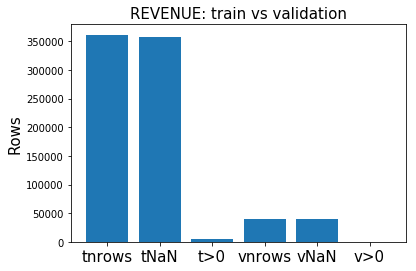

In [22]:
tnrows = trainx['totals.transactionRevenue'].size
vnrows = validx['totals.transactionRevenue'].size
tnrevs = trainx['totals.transactionRevenue'].dropna().size
vnrevs = validx['totals.transactionRevenue'].dropna().size
tzrevs = tnrows - tnrevs
vzrevs = vnrows - vnrevs

print ("trainx: nrows = {:6d}; NaN = {:4d}; >0 = {:4d}; {:1.2f}%".format(tnrows,tzrevs,tnrevs,tnrevs/(tnrows/100)))
print ("validx: nrows = {:6d}; NaN = {:4d}; >0 = {:4d}; {:1.2f}%".format(vnrows,vzrevs,vnrevs,vnrevs/(vnrows/100)))
mybar_rows([tnrows, tzrevs, tnrevs, vnrows, vzrevs, vnrevs], labels=["tnrows", "tNaN", "t>0", "vnrows", "vNaN", "v>0"], title="REVENUE: train vs validation")

In [23]:
# not managing to get the row number using panda functions; I need this if I use shuffle=True above
def get_row_number(arr, value):
    row = 0
    for v in arr:
        if v == value:
            return row
        else:
            row = row + 1

def get_testrow(df, dfx, arry, col, value):
    dfnames = sys._getframe(1).f_code.co_names[1:4]  # [0] is the function name
    i = df.index[(df[col] == value)].tolist()[0]
    r = get_row_number(dfx[col], value)
    print ("using revenue value = {:d} to check trainx/trainy".format(value))
    print ("{:8s}: value found at index {:d}, which is actually row {:d}".format(dfnames[0], i, r))
    print ("{:8s}: value found at index {:6d} is: {:1.0f}".format(dfnames[1], i, dfx.loc[i][col]))
    print ("{:8s}: value found at row   {:6d} is: {:1.0f}".format(dfnames[1], r, dfx.iloc[r][col]))
    print ("{:8s}: value found at row   {:6d} is: {:1.0f}".format(dfnames[2], r, arry[r]))
    assert dfx.loc[i][col] == arry[r]
    assert dfx.iloc[r][col] == arry[r]

# won't work when newtest is validation data
#get_testrow(newtrain, trainx, trainy, 'totals.transactionRevenue', 306670000)

### Drop totals.transactionRevenue
After checks, drop `totals.transactionRevenue`. Also, if fields `date` and `fullVisitorId` are not required for machine learning then they can be dropped now too (they were used for checks in previous cells). A summary is shown of trainx for visual confirmation of changes.

In [24]:
trainx.drop(columns=['totals.transactionRevenue'], inplace=True)
validx.drop(columns=['totals.transactionRevenue'], inplace=True)
assert set(trainx.columns) == set(validx.columns)
#assert set(trainx.columns) == set(testx.columns)
summary(trainx, info="basic")

DataFrame shape (361430, 37)
.....................................

,Null,dType,Type,Unique,Examples
totals.pageviews,92,float64,<class 'numpy.float64'>,151,"[9.0, 1.0, 34.0, 3.0, 10.0, 7.0, 2.0, 19.0, 5...."
totals.hits,0,int64,<class 'numpy.int64'>,203,"[10, 1, 53, 3, 14, 7, 2, 13, 24, 5, 29, 16, 30..."
hits.list.eCommerceAction.option,351357,object,<class 'str'>,4,"[nan, keep_Billing, keep_Review, keep_Payment]"
visitStartTimeHH,0,int64,<class 'numpy.int64'>,24,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
device.operatingSystem,4216,object,<class 'str'>,22,"[Macintosh, Android, Windows, nan, iOS, Samsun..."
trafficSource.adwordsClickInfo.slot,351230,object,<class 'str'>,6,"[nan, Google Display Network, Top, RHS, Google..."
hits.list.contentGroup.previousContentGroup2,128861,object,<class 'str'>,10,"[keep_Apparel, remainder, nan, keep_Drinkware,..."
geoNetwork.region,196925,object,<class 'str'>,260,"[nan, Maharashtra, California, Taoyuan County,..."
device.browser,0,object,<class 'str'>,61,"[Chrome, Samsung Internet, Opera Mini, Safari,..."
hits.list.transaction.affiliation,355609,object,<class 'str'>,3,"[nan, keep_Merchandise, remainder]"


### Functions for encoding
* get_unique_categories: for all columns - we'll decide later which ones we'll encode
* encode_columns: objects are always encoded (one-hot or label depending on qty of unique entries - see argument `onehot`); everything else is converted to float.

After the three data frames are encoded (train, validation and test) the three are aligned using train+valid, then train+test and lastly train+valid again just in case the previous align removed columns from train. A summary is shown of the encoded training data trainxe for visual confirmation of the changes.

In [25]:
def get_unique_categories(df, dfx, dft):
    aunique = {}
    for col in df.columns:
        aunique[col] = list(set(list(df[col].astype(str).unique()) +
                                list(dfx[col].astype(str).unique()) +
                                list(dft[col].astype(str).unique())))
        aunique[col].sort()
    return aunique

def encode_columns(df, ucats, onehot=50):
    sys.stdout.write("encoding "+sys._getframe(1).f_code.co_names[1])  # [0] is function name
    le = LabelEncoder()
    for col,coltype in df.dtypes.items():
        sys.stdout.write('.')
        sys.stdout.flush()
        if coltype == 'object':
            if (len(ucats[col]) > onehot):
                le.fit(ucats[col])
                df[col] = le.transform(df[col].astype('str'))
    df = pd.get_dummies(df)

    for col,coltype in df.dtypes.items():
        if coltype != 'float':
            df[col] = df[col].astype(float)

    print ("returned new shape",df.shape)
    return df

In [26]:
unique_categories = get_unique_categories(trainx, validx, testx)

trainxe = encode_columns(trainx.copy(), unique_categories, onehot=0)
validxe = encode_columns(validx.copy(), unique_categories, onehot=0)
testxe  = encode_columns(testx.copy(), unique_categories, onehot=0)

trainxe,validxe = trainxe.align(validxe, join='inner', axis=1)
trainxe,testxe  = trainxe.align(testxe, join='inner', axis=1)
trainxe,validxe = trainxe.align(validxe, join='inner', axis=1)
print ("trainxe shape after align", trainxe.shape)
print ("validxe shape after align", validxe.shape)
print ("testxe shape after align", testxe.shape)
assert set(trainxe.columns) == set(validxe.columns)
assert set(trainxe.columns) == set(testxe.columns)
assert set(trainxe.dtypes) == set(validxe.dtypes)
assert set(trainxe.dtypes) == set(testxe.dtypes)
summary(trainxe, info="basic")

encoding trainx.....................................returned new shape (361430, 37)
encoding validx.....................................returned new shape (40159, 37)
encoding testx......................................returned new shape (401589, 38)
trainxe shape after align (361430, 37)
validxe shape after align (40159, 37)
testxe shape after align (401589, 37)
DataFrame shape (361430, 37)
.....................................

,Null,dType,Type,Unique,Examples
totals.pageviews,92,float64,<class 'numpy.float64'>,151,"[9.0, 1.0, 34.0, 3.0, 10.0, 7.0, 2.0, 19.0, 5...."
totals.hits,0,float64,<class 'numpy.float64'>,203,"[10.0, 1.0, 53.0, 3.0, 14.0, 7.0, 2.0, 13.0, 2..."
hits.list.eCommerceAction.option,0,float64,<class 'numpy.float64'>,4,"[3.0, 0.0, 2.0, 1.0]"
visitStartTimeHH,0,float64,<class 'numpy.float64'>,24,"[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, ..."
device.operatingSystem,0,float64,<class 'numpy.float64'>,22,"[6.0, 0.0, 17.0, 21.0, 20.0, 12.0, 2.0, 5.0, 1..."
trafficSource.adwordsClickInfo.slot,0,float64,<class 'numpy.float64'>,6,"[5.0, 0.0, 4.0, 3.0, 2.0, 1.0]"
hits.list.contentGroup.previousContentGroup2,0,float64,<class 'numpy.float64'>,10,"[1.0, 9.0, 8.0, 4.0, 2.0, 3.0, 6.0, 0.0, 7.0, ..."
geoNetwork.region,0,float64,<class 'numpy.float64'>,260,"[267.0, 135.0, 36.0, 229.0, 236.0, 40.0, 189.0..."
device.browser,0,float64,<class 'numpy.float64'>,61,"[25.0, 55.0, 44.0, 53.0, 28.0, 43.0, 54.0, 33...."
hits.list.transaction.affiliation,0,float64,<class 'numpy.float64'>,3,"[1.0, 0.0, 2.0]"


<a id='neuralnet'></a>
# The Neural Net
LightLBM is used to create a baseline score using the following options:
* objective: regression: typically used when predicting quantities
* metric: rmse (root square loss): *try with np.expm1(y): l1 (absolute loss) l2 (square loss)*
* boosting: gbdt (Gradient Boosting Decision Tree), *try: rf (random_forest), dart (Dropouts meet Multiple Additive Regression Trees), goss (Gradient-based One-Side Sampling)*
* bagging: using independent methods and aggregating them afterwards

Suggestions for higher accurancy (with usual overfitting caveat):
* num_leaves: 30, try increasing
* max_bin: 255, try increasing
* learning_rate 0.1: try decreasing
* num_iterations: try increasing

[Top of page](#top)

#### Tweaks and previous scores
Scores for LightGBM with the following tweaks.
<br>*NOTE: splitting train/validation data was originally done by date - see `split_data` function above*
* `1.91` when using only `totals.hits`
* `1.73` when using only `totals.hits` `totals.pageviews` `date` `geoNetwork.city` `device.operatingSystem` `geoNetwork.country` `geoNetwork.subContinent`
* `1.71` when using useful_cols, but removed `dateMm` and `date`
* `1.71` when using useful_cols, but using `dateMm` instead of `date`
* `1.69` when using useful_cols plus `trafficSource.adwordsClickInfo.gclId`
* `1.68` when using useful_cols, but removed `fullVisitorId`
* `1.68` when using useful_cols, but change all columns to int()
* `1.68` when using useful_cols, but one_hot_encoding for <0 <50 <150 (<500 took hours to encode)
* `1.68` when using useful_cols, but changed LightGBM `num_leaves` to 60 (was 30)
* `1.68` when using useful_cols, but changed LightGBM `learning_rate` to 0.01 (was 0.1) - took 2000 iterations to get there
* `1.68` when using useful_cols
* `1.67` when using useful_cols and used only 1 month for validation data
* `1.60` when using useful_cols and train_test_split(..., test_data=0.2, shuffle=False)
* `1.60` when using useful_cols and train_test_split(..., test_data=0.1, shuffle=True)
* `1.59` when using useful_cols and train_test_split(..., test_data=0.1, shuffle=False) *NOTE: sometimes I get `1.60`*

In [27]:
def train_nn(trainx, trainy, validx, validy, testx):
    params = {
        "objective"         : "regression",
        "metric"            : "rmse", 
        "num_leaves"        : 30,
        "min_child_samples" : 100,
        "learning_rate"     : 0.1,
        "bagging_fraction"  : 0.7,
        "feature_fraction"  : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed"      : 2018,
        "verbosity"         : -1
    }
    
    trainlgb = lgb.Dataset(trainxe, label=trainy)
    validlgb = lgb.Dataset(validxe, label=validy)
    return lgb.train(params, trainlgb, 5000, valid_sets=[validlgb], early_stopping_rounds=200, verbose_eval=100)

nn = train_nn(trainxe, np.log1p(trainy), validxe, np.log1p(validy), testxe)
predy = nn.predict(testxe, num_iteration=nn.best_iteration)
predvy = nn.predict(validxe, num_iteration=nn.best_iteration)

Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.131729
[200]	valid_0's rmse: 0.129905
[300]	valid_0's rmse: 0.130337
[400]	valid_0's rmse: 0.130828
Early stopping, best iteration is:
[250]	valid_0's rmse: 0.129443


### Results
For both validation and test submission, in the next two respective cells, we have to:
<br> &nbsp;&nbsp; (a) set to 0 any value &lt; 0;
<br> &nbsp;&nbsp; (b) sum the revenue per visitor (`np.expm1` is the inverse of `log1p`);
<br> &nbsp;&nbsp; (c) take `log1p` of the new values.

For the validation, the array `allZeros` is representative of the worst score attainable by a non-learning algorithm. It's as good and sometimes slightly better than random values. *NOTE: This value is 1.97 because validy is 10% of the training data, but expect it to increase/decrease as validy's % of training data increases/decreases.*

In [28]:
def rmse_log1p(df, col1, col2):
    return np.sqrt(metrics.mean_squared_error(np.log1p(df[col1].values), np.log1p(df[col2].values)))

predvy[predvy<0] = 0
validation = pd.DataFrame({'fullVisitorId':             validvids,
                           'totals.transactionRevenue': validy,
                           'totals.predictedRevenue':   np.expm1(predvy),
                           'totals.allZeros':           [0] * len(validy) })

print("RMSE score where prediction always 0: ", rmse_log1p(validation, 'totals.transactionRevenue', 'totals.allZeros'))
print("RMSE score for validation (ungrouped):", rmse_log1p(validation, 'totals.transactionRevenue', 'totals.predictedRevenue'))
validation = validation.groupby('fullVisitorId')['totals.transactionRevenue','totals.predictedRevenue'].sum().reset_index()
print("RMSE score for validation (grouped):  ", rmse_log1p(validation, 'totals.transactionRevenue', 'totals.predictedRevenue'))

RMSE score where prediction always 0:  1.96265618008
RMSE score for validation (ungrouped): 0.128009438777
RMSE score for validation (grouped):   0.141306287201


In [44]:
#predy[predy<0] = 0
#(predy > 18.9).sum()   # testing how many are over this threshold
predy[predy<=18.9] = 0  # this ensures only 0.1% are above 0 (as per last year)

submission = pd.DataFrame({'fullVisitorId':       testvids,
                           'PredictedLogRevenue': np.expm1(predy)})
submission = submission.groupby('fullVisitorId')['PredictedLogRevenue'].sum().reset_index()

print (submission['fullVisitorId'].nunique())
assert 296530 == submission['fullVisitorId'].nunique()  # Kaggle informs us that there can only be 296530 lines

submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission.to_csv(submission_path, index=False)

296530


[Top of page](#top)